# Pytorch LSTM example 

In [524]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
%matplotlib inline

In [525]:
use_gpu=torch.cuda.is_available()
print(use_gpu)

True


In [526]:
data_csv = pd.read_csv('data/international-airline-passengers.csv', usecols=[1])
look_back=20

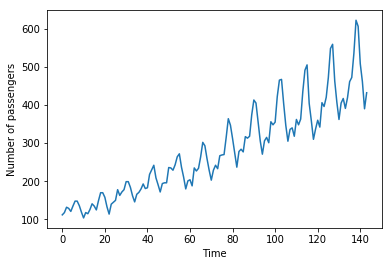

In [527]:
plt.plot(data_csv)
plt.xlabel("Time")
plt.ylabel("Number of passengers")
plt.show()

In [528]:

data_csv = data_csv.dropna()
dataset = data_csv.values
dataset = dataset.astype('float32')
max_value = np.max(dataset)
min_value = np.min(dataset)
scalar = max_value - min_value
dataset = list(map(lambda x: x / scalar, dataset))

In [529]:
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

In [530]:

data_X, data_Y = create_dataset(dataset, look_back)
print(look_back)

20


In [531]:

train_size = int(len(data_X) * 0.7)
test_size = len(data_X) - train_size
train_X = data_X[:train_size]
train_Y = data_Y[:train_size]
test_X = data_X[train_size:]
test_Y = data_Y[train_size:]

In [542]:


train_X = train_X.reshape(-1, 1, look_back)
train_Y = train_Y.reshape(-1, 1, 1)
test_X = test_X.reshape(-1, 1, look_back)

train_x = torch.from_numpy(train_X).cuda()
train_y = torch.from_numpy(train_Y).cuda()
test_x = torch.from_numpy(test_X).cuda()
print(train_X.size)

1720


In [533]:
from torch import nn
from torch.autograd import Variable

In [534]:

class lstm_reg(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1, num_layers=2):
        super(lstm_reg, self).__init__()
        
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers) # rnn
        self.reg = nn.Linear(hidden_size, output_size) 
        
    def forward(self, x):
        x, _ = self.rnn(x) # (seq, batch, hidden)
        s, b, h = x.shape
        x = x.view(s*b, h)
        x = self.reg(x)
        x = x.view(s, b, -1)
        return x
    
    def predict(self, inp, input_size, future=0):
        outputs=[]
        for i in range(future):# if we should predict the future
            x, _ = self.rnn(inp) # (seq, batch, hidden)
            s, b, h = x.shape
            x = x.view(s*b, h)
            x = self.reg(x)
            x = x.view(s, b, -1)
            outputs += [x]
            inp[:,:,:(input_size-1)]=inp[:,:,1:]
            inp[:,:,-1]=x.item()
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

In [535]:
net = lstm_reg(look_back, 4).cuda()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)

In [536]:
import time
time0=time.time()
for e in range(3000):
    var_x = Variable(train_x)
    var_y = Variable(train_y)

    out = net(var_x)
    loss = criterion(out, var_y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (e + 1) % 100 == 0: 
        print('Epoch: {}, Loss: {:.5f}'.format(e + 1, loss.item()))
time1=time.time()
print(time1-time0)

Epoch: 100, Loss: 0.01847
Epoch: 200, Loss: 0.00531
Epoch: 300, Loss: 0.00203
Epoch: 400, Loss: 0.00153
Epoch: 500, Loss: 0.00110
Epoch: 600, Loss: 0.00085
Epoch: 700, Loss: 0.00075
Epoch: 800, Loss: 0.00065
Epoch: 900, Loss: 0.00061
Epoch: 1000, Loss: 0.00052
Epoch: 1100, Loss: 0.00047
Epoch: 1200, Loss: 0.00042
Epoch: 1300, Loss: 0.00038
Epoch: 1400, Loss: 0.00035
Epoch: 1500, Loss: 0.00032
Epoch: 1600, Loss: 0.00030
Epoch: 1700, Loss: 0.00029
Epoch: 1800, Loss: 0.00027
Epoch: 1900, Loss: 0.00026
Epoch: 2000, Loss: 0.00025
Epoch: 2100, Loss: 0.00025
Epoch: 2200, Loss: 0.00024
Epoch: 2300, Loss: 0.00024
Epoch: 2400, Loss: 0.00023
Epoch: 2500, Loss: 0.00023
Epoch: 2600, Loss: 0.00022
Epoch: 2700, Loss: 0.00022
Epoch: 2800, Loss: 0.00021
Epoch: 2900, Loss: 0.00021
Epoch: 3000, Loss: 0.00021
38.52178144454956


In [537]:
net = net.eval() 

In [543]:
data_X = train_X.reshape(-1, 1, look_back)
data_X = torch.from_numpy(data_X).cuda()
var_data = Variable(data_X)
pred_test = net(var_data) 



In [550]:
print(test_x[0])
t=data_X[0].clone()
print(t.unsqueeze(1)[0,:,:])
print(net(t.unsqueeze(0)))
pred_test=net.predict(t.unsqueeze(1)[:,:,:],look_back , 140)
print(pred_test)

tensor([[ 0.6120,  0.6042,  0.6139,  0.7220,  0.7973,  0.7819,  0.6853,
          0.5907,  0.5232,  0.5907,  0.6081,  0.5811,  0.6873,  0.6718,
          0.6853,  0.8147,  0.8977,  0.9015,  0.7799,  0.6699]], device='cuda:0')
tensor([[ 0.2162,  0.2278,  0.2548,  0.2490,  0.2336,  0.2606,  0.2857,
          0.2857,  0.2625,  0.2297,  0.2008,  0.2278,  0.2220,  0.2432,
          0.2722,  0.2606,  0.2413,  0.2876,  0.3282,  0.3282]], device='cuda:0')
tensor([[[ 0.3060]]], device='cuda:0')
tensor([[[ 0.3060],
         [ 0.2891],
         [ 0.2848],
         [ 0.2951],
         [ 0.2984],
         [ 0.3105],
         [ 0.3241],
         [ 0.3206],
         [ 0.3242],
         [ 0.3423],
         [ 0.3510],
         [ 0.3427],
         [ 0.3333],
         [ 0.3270],
         [ 0.3262],
         [ 0.3292],
         [ 0.3341],
         [ 0.3424],
         [ 0.3483],
         [ 0.3485],
         [ 0.3520],
         [ 0.3569],
         [ 0.3558],
         [ 0.3499],
         [ 0.3456],
         

In [551]:

pred_test = pred_test.view(-1).cpu().data.numpy()
print(pred_test)

[0.30601543 0.2890532  0.28477722 0.2951352  0.298418   0.31049144
 0.32408804 0.32059872 0.3242135  0.3422773  0.35096878 0.34267992
 0.33330566 0.32704794 0.32618654 0.3292294  0.33405447 0.3423583
 0.3483051  0.34851897 0.35200638 0.3569156  0.3557678  0.34991068
 0.34564555 0.3437001  0.343952   0.3466     0.35070783 0.35533184
 0.3576867  0.3582012  0.35914886 0.35907954 0.35648453 0.35336024
 0.35180265 0.35163218 0.35267317 0.3549499  0.3576281  0.3597346
 0.36045414 0.36031526 0.35985392 0.35862386 0.3568213  0.35553086
 0.35530347 0.3558442  0.35701257 0.3585841  0.35996544 0.360676
 0.36060518 0.36007136 0.35927576 0.35826796 0.35740942 0.3571164
 0.35742253 0.35809904 0.3589893  0.3598544  0.3603775  0.36041886
 0.36005765 0.35949486 0.35887676 0.35834664 0.35810357 0.3582375
 0.3586526  0.35918707 0.35970813 0.36006296 0.36013353 0.35993046
 0.3595608  0.3591566  0.35882288 0.35865146 0.35870153 0.35894352
 0.35927808 0.3596003  0.3598274  0.35989398 0.35978597 0.3595578
 0

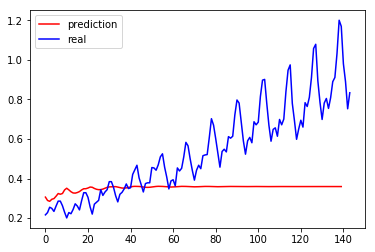

In [552]:

plt.plot(pred_test, 'r', label='prediction')
plt.plot(dataset, 'b', label='real')
plt.legend(loc='best')